# Plaidoirie Northpointe

## Introduction

Ce notebook vise à répondre à l'accusation de Propublica concernant le caractère raciste de l'algorithme COMPAS (Correctional Offender Management Profiling for Alternative Sanctions) développé par Northpointe. Nous allons montrer que cette accusation est infondée pour plusieurs raisons :

1. Northpointe et Propublica utilisent deux critères distincts pour mesurer la fairness de l'algorithme COMPAS. Les deux sont valables et il n'est pas possible de choisir un meilleur critère. Par ailleurs, ils ne peuvent pas être satisfaits parfaitement tous les deux. Ainsi, le fait que COMPAS vérifie le critère Northpointe mais pas celui Propublica ne signifie pas qu'il existe des biais racistes dans l'algorithme.

2. Les différences observées entre les Afro-Américains et les Caucasiens en termes de score ne sont pas dues à l'origine ethnique mais à d'autres variables, notamment l'âge, qui jouent un rôle important dans la détermination du score et qui diffèrent entre ces deux groupes.

3. COMPAS, comme tout algorithme, peut se tromper. Mais COMPAS est seulement un outil d'aide à la prise de décision, qui ne remplace pas la décision humaine donc ce type d'erreur reste sous contrôle du juge. De plus, les images diffusées par Propublica montrant des "aberrations" (une personne A ayant l'air sensiblement moins dangereuse qu'une personne B mais avec un score plus élevé) sont trompeuses.

Détaillons ces différents arguments en nous appuyant sur les résultats de l'algorithme COMPAS.

### Préparation des données

Afin de pouvoir les utiliser facilement par la suite, nous commençons par préparer nos données notamment en remplaçant les variables catégorielles par des chiffres. Par exemple, dans le cas de l'origine ethnique, nous remplaçons Caucasien par 0 et Afro-Américain par 1.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.append('../')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from functools import partial

from collections import Counter
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/EA MAP511/compas-scores-two-years.csv')

In [ ]:
dd = df[['id','sex', 'age', 'age_cat', 'race', 'decile_score', 'priors_count', 'score_text', 'c_charge_degree', 'two_year_recid', 'is_recid', 'days_b_screening_arrest',
        'juv_fel_count', 'juv_misd_count']].replace({
    'Greater than 45':'Above_FourtyFive',
    'Less than 25':'Below_TwentyFive',
    '25 - 45': 'Between_25_45',
    'M':'Misdemeanor',
    'F':'Felony'
})

dd = dd[(dd.days_b_screening_arrest <= 30) & (dd.days_b_screening_arrest >=-30)]\
        .drop(columns=['days_b_screening_arrest','is_recid'])\
        .assign(score_factor = lambda x: x['score_text'].map(lambda y: 1 if y!='Low' else 0))
dd = dd[(dd.race=='African-American') | (dd.race=='Caucasian')]
dd = dd.assign(
    race = lambda x: (x['race'] == 'Caucasian')*1,
    sex = lambda x: (x.sex == 'Male')*1,
    felony = lambda x: (x.c_charge_degree == 'Felony')*1
         ).drop(columns = ['score_text'])
dd = dd.replace({'Above_FourtyFive':1,'Below_TwentyFive' : -1,'Between_25_45': 0, 'Male':1, 'Female':-1
                ,'African-American' : 1,'Caucasian' :0,
                 'Low': -1,'High' : 1, 'Medium' : 0,
                'Felony': 1, 'Misdemeanor' : 0})

dd.head()

,id,sex,age,age_cat,race,decile_score,priors_count,c_charge_degree,two_year_recid,juv_fel_count,juv_misd_count,score_factor,felony
1,3,1,34,0,0,3,0,1,1,0,0,0,1
2,4,1,24,-1,0,4,4,1,1,0,0,0,1
6,8,1,41,0,1,6,14,1,1,0,0,1,1
8,10,0,39,0,1,1,0,0,0,0,0,0,0
10,14,1,27,0,1,4,0,1,0,0,0,0,1


## 1. Question du meilleur critère

### 1.1. Définitions et présentation des critères de fairness

Avant de commencer notre argumentaire, commençons par redonner quelques définitions :

- **Critère Northpointe** : probabilité de récidiver sachant le score (on peut donc regarder deux probabilités différentes, celle sachant que le score est élevé et celle sachant que le score est bas)
- **Critère Propublica** : probabilité du score sachant le statut de récidive (encore une fois, on peut regarder deux probabilités, celle sachant que la personne a récidivé, et celle sachant que la personne n'a pas récidivé).

Ces deux critères correspondent à deux mesures de fairness qui sont :
- **Predictive parity** : la FPP et la FNP sont égales entre les différents groupes où **FPP** est la false positive prediction (parmi ceux classés haut risque, ceux qui n’ont pas récidivé) et **FNP** est la false negative prediction (parmi ceux classés bas risque, ceux qui ont récidivé).
- **Equality of odds** : la FPC et la FNC sont égales entre les différents groupes où **FPC** est la false positive classification (parmi ceux qui n'ont pas récidivé, ceux qui ont été classés haut risque) et **FNC** est la false negative classification (parmi ceux qui ont récidivé, ceux qui ont été classés bas risque). Cf. partie 2.4 pour une définition précise.

Propublica et Northpointe regardent donc deux critères distincts pour mesurer la fairness de l'algorithme COMPAS.

Avec le critère utilisé par Northpointe, nous pouvons montrer que cet algorithme ne fait aucune discrimination envers les Afro-Américains. Ainsi, si on représente graphiquement le taux de récidive par rapport au score, on observe tout d'abord que COMPAS fonctionne : plus le score est élevé et plus le taux de récidive est important. De plus, on remarque qu'il n'y a pas de différence entre les Afro-Américains et les Caucasiens car une valeur de score signifie la même chose quelle que soit l'origine ethnique (mêmes taux de récidive).

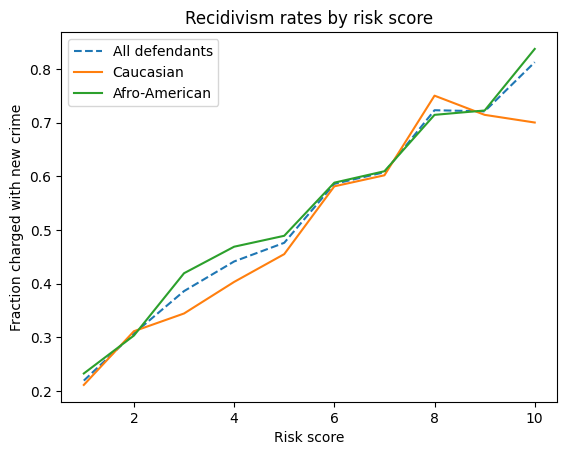

In [ ]:
res=np.zeros(10)
pes=np.zeros(10)
kes=np.zeros(10)
for i in range(1,11):
    a=dd[dd['decile_score']==i].copy()
    b=a[a['race']==1].copy()
    c=a[a['race']==0].copy()
    kes[i-1]=a['two_year_recid'].mean()
    res[i-1]=b['two_year_recid'].mean()
    pes[i-1]=c['two_year_recid'].mean()
plt.figure()
plt.plot(np.arange(1,11),kes,label='All defendants', linestyle="--")
plt.plot(np.arange(1,11),res,label='Caucasian')
plt.plot(np.arange(1,11),pes,label = 'Afro-American')
plt.legend()
plt.title('Recidivism rates by risk score')
plt.xlabel('Risk score')
plt.ylabel('Fraction charged with new crime')
plt.show()

Nous pouvons recalculer le critère de predictive parity et voir qu'il est satisfait.

In [ ]:
def npcriteria_negative(data1,data2,two_year_recid="two_year_recid",score_factor="score_factor"):
  data1recid=data1[data1["score_factor"]==0]
  nb1=Counter(data1recid["two_year_recid"])
  npcriteria1=nb1[1]/len(data1recid)
  data2recid=data2[data2["score_factor"]==0]
  nb2=Counter(data2recid["two_year_recid"])
  npcriteria2=nb2[1]/len(data2recid)
  print("Share of defendants who recidivated among those classified low risk:")
  print("Among Afro-Americans --> FNP : %.2f%%,  " % (100*npcriteria1), "error : %.2f%%" % (100*1.96*np.sqrt(npcriteria1*(1-npcriteria1)/len(data1recid))))
  print("Among Caucasians --> FNP : %.2f%%,  " % (100*npcriteria2), "error : %.2f%%" % (100*1.96*np.sqrt(npcriteria2*(1-npcriteria2)/len(data2recid))))
  print("")

def npcriteria_positive(data1,data2,two_year_recid="two_year_recid",score_factor="score_factor"):
  data1recid=data1[data1["score_factor"]==1]
  nb1=Counter(data1recid["two_year_recid"])
  npcriteria1= 1- nb1[1]/len(data1recid)
  data2recid=data2[data2["score_factor"]==1]
  nb2=Counter(data2recid["two_year_recid"])
  npcriteria2=1- nb2[1]/len(data2recid)
  print("Share of defendants who didn't recidivate among those classified high risk:")
  print("Among Afro-Americans --> FPP :  %.2f%%,  " % (100*npcriteria1),"error : %.2f%%" % (100*1.96*np.sqrt(npcriteria1*(1-npcriteria1)/len(data1recid))))
  print("Among Caucasians --> FPP : %.2f%%,  " % (100*npcriteria2),"error : %.2f%%" % (100*1.96*np.sqrt(npcriteria2*(1-npcriteria2)/len(data2recid))))

npcriteria_negative(dd[dd['race']==0],dd[dd['race']==1])
npcriteria_positive(dd[dd['race']==0],dd[dd['race']==1])

Share of defendants who recidivated among those classified low risk:
Among Afro-Americans --> FNP : 35.14%,   error : 2.55%
Among Caucasians --> FNP : 29.00%,   error : 2.37%

Share of defendants who didn't recidivate among those classified high risk:
Among Afro-Americans --> FPP :  35.05%,   error : 2.19%
Among Caucasians --> FPP : 40.52%,   error : 3.65%


COMPAS vérifie donc le critère de predictive parity : les erreurs sont très proches entre les différents groupes. La critique de Propublica repose sur le fait que COMPAS ne vérifie pas le critère d'equality of odds. La question est maintenant de savoir s'il existe un critère meilleur que l'autre. Nous allons voir deux choses :
1. En matière de fairness, il n'est pas possible de conclure sur un critère par rapport à l'autre, les deux se valent.
2. En outre, il n'est pas possible de satisfaire parfaitement ces deux critères. Ceux-ci sont incompatibles.

### 1.2. Quel est le meilleur critère ?

La notion de fairness en matière d'algorithmes n'est pas évidente. De nombreux critères existent : equality of odds, disparate impact (ou statistical parity), predictive parity... Dans le cas de Northpointe et Propublica, il n'est pas possible de dire simplement si un critère est plus valable que l'autre.

Prenons par exemple le critère utilisé par Propublica. L'equality of odds repose sur le principe qu'un algorithme devrait traiter deux groupes similaires également, c'est-à-dire que tout le monde dans le groupe des récidivants (ou des non récidivants) devrait être traité de la même manière, quelle que soit l'origine ethnique. Le critère de Northpointe repose également sur le principe d'égalité de traitement : un score doit avoir la même signification quelle que soit l'origine ethnique.

Il semble donc qu'aucun critère ne soit nécessairement plus valide qu'un autre, ce qui est confirmé par le fait que la littérature scientifique n'en aucun en particulier.



### 1.3. Incompatibilité des critères

Nous avons vu que le critère utilisé par Northpointe signifie qu'un score veut dire la même chose quelque soit l'origine ethnique. Imaginons que ce ne soit pas le cas et que nous attribuions systématiquement aux Caucasiens des scores plus élevés qu'aux Afro-Américains présentant le même risque, dans le but d'atténuer les critiques de ProPublica. Il s'agirait d'une violation d'une principe de l'égalité de traitement. La question qui se pose alors est pouvons nous garder ce critère et satisfaire simultanément l'égalité des taux d'erreurs (critère Propublica) ?

Cette question a été largement étudiée et nous pouvons mettre en avant le "théorème d'impossibilité" mis en avant par Kleinberg (2016, https://arxiv.org/abs/1609.05807) ou Chouldechova (2017, https://www.liebertpub.com/doi/10.1089/big.2016.0047). Ce théorème dit que si un test est calibré en termes de taux d'erreur (de tel sorte que les taux d'erreur soient égaux entre les groupes), alors il ne l'est pas en termes de valeurs prédictives et inversement :
- Si nous rendons les taux d'erreur plus égaux, nous rendons les valeurs prédictives plus injustes.
- Si nous rendons les valeurs prédictives plus égales, nous rendons les taux d'erreur plus injustes. \

Le problème est que la prévalence de la récidive est différente dans les deux groupes : environ 39 % des prévenus Caucasiens ont été accusés d'un autre délit dans les deux ans, contre 51 % des prévenus Afro-Américains. Tant que c'est le cas (pour n'importe quel groupe), les valeurs prédictives et les taux d'erreur ne peuvent pas être "justes" en même temps. Dans le cas de COMPAS, les deux critères sont donc incompatibles.

In [ ]:
white = dd[(dd['race'] == 1)]
black = dd[(dd['race'] == 0)]

# Calcul de la prévalence de la récidive
prevalence_white = (white['two_year_recid'] == 1).mean() * 100
prevalence_black = (black['two_year_recid'] == 1).mean() * 100

print(f"Prévalence de la récidive chez les Caucasiens : {prevalence_white:.2f}%")
print(f"Prévalence de la récidive chez les Afro-Américains : {prevalence_black:.2f}%")

Prévalence de la récidive chez les Caucasiens : 39.09%
Prévalence de la récidive chez les Afro-Américains : 52.31%


Ainsi, la critique de Propublica n'est pas valable puisqu'elle repose sur le fait qu'un critère n'est pas satisfait. Or, non seulement il n'est pas possible de dire que le critère utilisé par Propublica est meilleur que celui utilisé par Northpointe mais en plus, ces deux critères sont incompatibles. COMPAS n'a donc pas de biais racistes et est considéré comme juste même s'il ne satisfait pas le critère utilisé par Propublica.

## 2. L'impact d'autres variables

Nous avons vu précédemment que le critère avancé par Propublica dans son accusation ne contredisait pas celui utilisé par Northpointe. Au contraire, un algorithme qui vérifie seulement un de ces deux critères peut être considéré comme juste, sans biais racial, comme c'est le cas pour COMPAS.

Par ailleurs, un autre argument qui nous fait rejeter l'accusation de l'existence de biais racistes par COMPAS est l'influence d'autres variables qui ont un lien avec l'origine ethnique sur le score, notamment l'âge. En effet, comme nous allons le démontrer dans cette partie, l'âge a un effet très important dans la détermination du score (les plus jeunes sont estimés plus à risque de récidiver).

Or, il y a plus de jeunes chez les Afro-Américains que chez les Caucasiens. Ainsi, la différence observée entre ces deux groupes au niveau de la répartition des scores s'explique par cette répartition inégale de l'âge. Quand on conditionne sur le groupe des "jeunes" (moins de 25 ans), on observe une distribution égalitaire des scores entre Afro-Américains et Caucasiens et des indices de fairness très satisfaisants.

### 2.1. Corrélation entre score et âge

Pour montrer cela, commençons par représenter le tableau de corrélation des différentes variables présentes dans le data set.

Text(0.5, 1.0, 'Plot de la correlation dans les données de training')

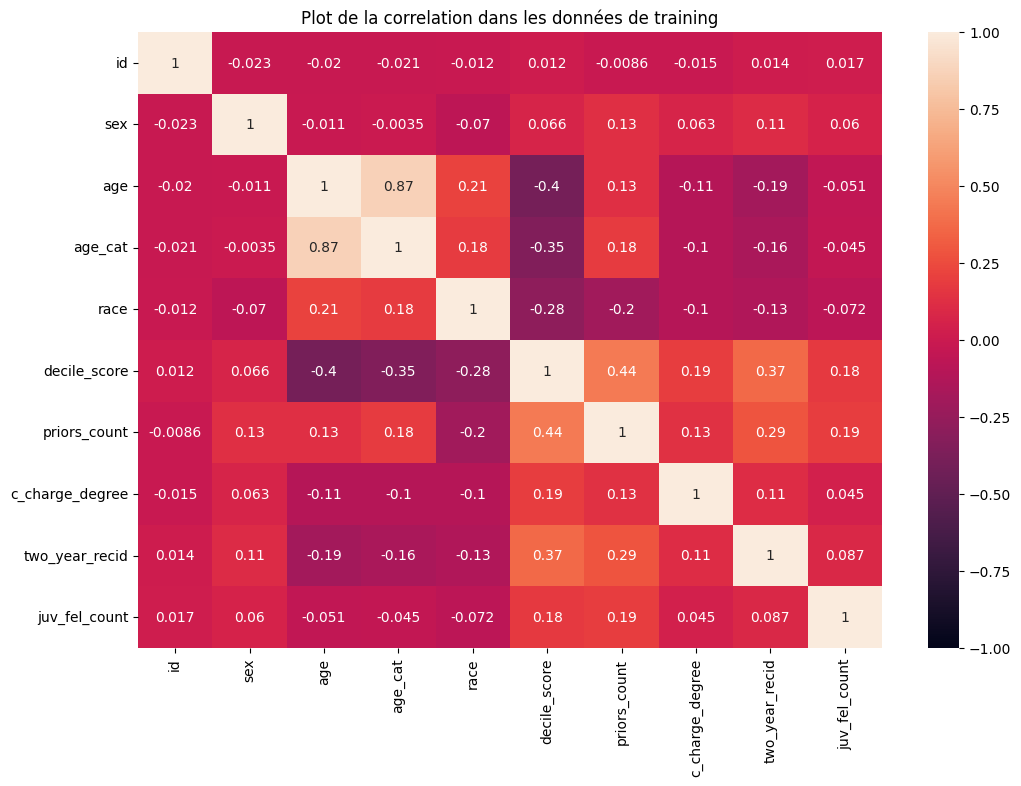

In [ ]:
data_train_corr = dd
data_corr = data_train_corr.corr().iloc[0:10, 0:10]

plt.figure(figsize=(12,8))

sns.heatmap(data = data_corr, annot = True, vmin= - 1, vmax=1)
plt.title("Plot de la correlation dans les données de training")

La première remarque que nous pouvons faire est que le score (variable decile_score) semble être fortement négativement corrélée à l'âge (c'est-à-dire, plus la personne est jeune, plus son score est élevé) avec une corrélation de -0.4. C'est une des variables qui a le plus d'impact sur le score avec les antécédents judiciaires (variable priors_count) avec une corrélation positive de 0.44. L'ethnicité intervient également mais nous allons voir que cette corrélation est capturée par l'effet de l'âge.

### 2.2. Modèle pour déterminer précisément l'impact de l'âge sur le score

Afin de vérifier plus précisément le rôle joué par l'âge dans la détermination du score, nous avons essayé de reproduire l'algorithme de COMPAS grâce à un modèle de régression logistique. L'objectif est de prédire si la personne va récidiver ou non (dans le code, on prédit la variable 'two_year_recid') et de lui attribuer un score sur 10 comme pour COMPAS.

Cela va nous permettre de vérifier notre intuition et de comprendre quelles variables jouent le plus sur la détermination du score.

In [ ]:
data_train = dd.loc[dd['id']<8763]
data_test = dd.loc[dd['id']>=8763]

X_train = pd.get_dummies(data_train[['sex','age_cat','race','priors_count','c_charge_degree']], drop_first=True)
X_train = sm.add_constant(X_train)
y_train = data_train['two_year_recid']

X_test = pd.get_dummies(data_test[['sex','age_cat','race','c_charge_degree','priors_count']], drop_first=True)
X_test = sm.add_constant(X_test)
y_test = data_test['two_year_recid']

model_GLM = sm.GLM(y_train, X_train, family=sm.families.Binomial())
result_GLM = model_GLM.fit()

In [ ]:
y_pred = result_GLM.predict(X_test)
y_pred_class = (y_pred > 0.5).astype(int)

accuracy = np.sum(y_test==y_pred_class)/len(y_test)
print(f'Accuracy : {accuracy}')

Accuracy : 0.6420454545454546


Avec notre modèle, nous obtenons une accuracy de 0.64 qui correspond bien à celle obtenue par COMPAS. Nous allons maintenant pouvoir regarder quelles sont les variables qui ont le plus d'importance dans le modèle.

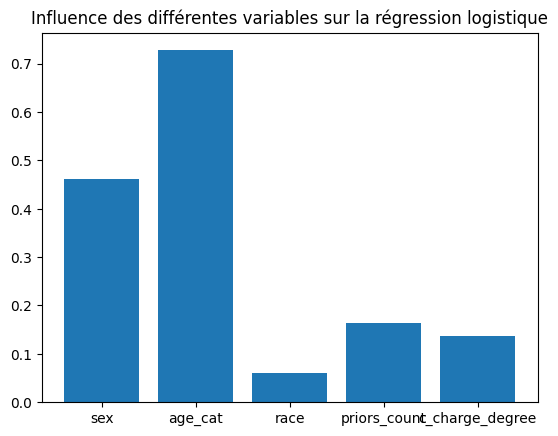

In [ ]:
coeffs=result_GLM.params
plt.figure()
plt.bar(['sex','age_cat','race','priors_count','c_charge_degree'],np.abs(coeffs[1:]))
plt.title('Influence des différentes variables sur la régression logistique' )
plt.show()

On observe ainsi que l'âge joue un rôle prédominant dans la détermination du score, bien avant l'origine ethnique, ce qui confirme notre première analyse. Celle-ci joue un léger rôle mais nous allons voir que ceci s'explique par la distribution différenciée de l'âge chez les Afro-Américains et chez les Caucasiens. Nous avons utilisé moins de variables pour faire notre prédiction que de variables disponibles dans le tableau de corrélation afin de simplifier le modèle.

### 2.3. Distribution de l'âge en fonction des origines ethniques

Regardons maintenant la distribution d'âge au sein des différentes catégories de la population.

In [ ]:
table = pd.crosstab(dd['age_cat'], dd['race'])
table.columns=["Black","White"]
new_index_names = {
    -1: 'Moins de 25 ans',
    0: '25-45 ans',
    1: 'Plus de 45 ans',
}
table.rename(index=new_index_names, inplace=True)
print(table)

                 Black  White
age_cat                      
Moins de 25 ans    809    347
25-45 ans         1898   1128
Plus de 45 ans     468    628


In [ ]:
print('Il y a {:.2f} % de moins de 25 ans dans la population noire étudiée.'.format(809/(1898+468+809)*100))
print('Il y a {:.2f} % de moins de 25 ans dans la population blanche étudiée.'.format(347/(1128+628+347)*100))

Il y a 25.48 % de moins de 25 ans dans la population noire étudiée.
Il y a 16.50 % de moins de 25 ans dans la population blanche étudiée.


Ainsi, on observe une proportion de jeunes beaucoup plus importante chez les Afro-Américains que chez les Caucasiens.

Puisque l'âge a un effet particulièrement important sur le score, il semble alors que la différence de distribution du score observée entre Afro-Américains et Caucasiens s'explique par cette différence de structure de la population.

### 2.4. Disparition des différences entre origines ethniques lorsqu'on conditionne par l'âge

Pour vérifier cela, nous avons comparé la distribution des scores pour les Afro-Américains de moins de 25 ans et pour les Caucasiens de moins de 25 ans.

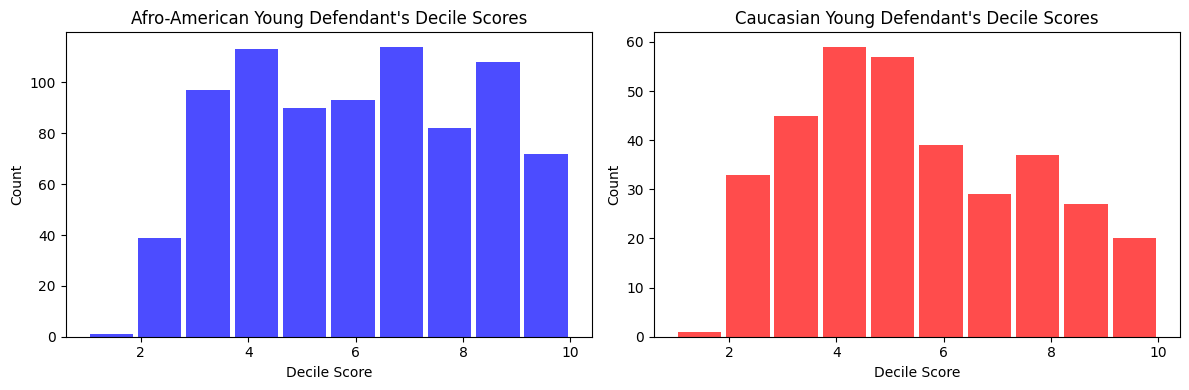

In [ ]:
df_black = dd[dd['race']==0]
df_black_young = df_black[df_black['age_cat']==-1]
df_white = dd[dd['race']==1]
df_white_young = df_white[df_white['age_cat']==-1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot for Black defendants
ax1.hist(df_black_young['decile_score'], bins=10, color='b', alpha=0.7,rwidth=0.9)
ax1.set_xlabel('Decile Score')
ax1.set_ylabel('Count')
ax1.set_title("Afro-American Young Defendant's Decile Scores")

# Plot for White defendants
ax2.hist(df_white_young['decile_score'], bins=10, color='r', alpha=0.7,rwidth=0.9)
ax2.set_xlabel('Decile Score')
ax2.set_ylabel('Count')
ax2.set_title("Caucasian Young Defendant's Decile Scores")

plt.tight_layout()
plt.show()

On voit alors que la distribution des scores, lorsque l'on conditionne par l'âge, est beaucoup plus équitable. Pour vérifier cela de manière plus rigoureuse, nous avons calculé les différents indices de fairness les plus couramment utilisés notamment le disparate impact et l'equality of odds.

**Disparate impact**

Une mesure de fairness de base est le disparate impact c'est à dire :

$$
DI(\hat{Y}, S) = \frac{\mathbb{P}(\hat{Y} = 1|S = 0)}{\mathbb{P}(\hat{Y} = 1|S = 1)}
$$

avec $S$ la variable sensible (ici l'origine ethnique) et $\hat{Y}$ la prédiction (par exemple 1 score élevé, 0 score faible). L'objectif est que le disparate impact soit le plus proche de 1 que possible, c'est-à-dire que la variable sensible n'influence pas la prédiction.

In [ ]:
from scipy.stats import norm
alpha = 0.05  # Pour un niveau de confiance de 95 %
z_value = norm.ppf(1 - alpha / 2)

DI_condi_num = dd[dd['race']==1]
DI_condi_num = DI_condi_num[DI_condi_num['age_cat']==-1]
DI_pos_num = DI_condi_num[DI_condi_num['score_factor']==1]
DI_proba_num = len(DI_pos_num)/len(DI_condi_num)

print("Pour la population caucasienne, la probabilité que la personne ait été catégorisée comme à haut risque \n alors qu'elle a moins de 25 ans est comprise entre",
      [round(DI_proba_num - z_value * np.sqrt((DI_proba_num * (1 - DI_proba_num)) / len(DI_condi_num)), 2),
       round(DI_proba_num + z_value * np.sqrt((DI_proba_num * (1 - DI_proba_num)) / len(DI_condi_num)), 2)])

Pour la population caucasienne, la probabilité que la personne ait été catégorisée comme à haut risque 
 alors qu'elle a moins de 25 ans est comprise entre [0.55, 0.65]


In [ ]:
DI_condi_denum = dd[dd['race']==0]
DI_condi_denum = DI_condi_denum[DI_condi_denum['age_cat']==-1]
DI_pos_denum = DI_condi_denum[DI_condi_denum['score_factor']==1]
DI_proba_denum = len(DI_pos_denum)/len(DI_condi_denum)

print("Pour la population afro-américaine, la probabilité que la personne ait été catégorisée comme à haut risque \n alors qu'elle a moins de 25 ans est comprise entre",
      [round(DI_proba_denum - z_value * np.sqrt((DI_proba_denum * (1 - DI_proba_denum)) / len(DI_condi_denum)), 2),
       round(DI_proba_denum + z_value * np.sqrt((DI_proba_denum * (1 - DI_proba_denum)) / len(DI_condi_denum)), 2)])

Pour la population afro-américaine, la probabilité que la personne ait été catégorisée comme à haut risque 
 alors qu'elle a moins de 25 ans est comprise entre [0.66, 0.72]


Ici, notre disparate impact est autour de $0.8$ ce qui est considéré comme acceptable (règle du $4/5^{ème}$ par le State of California Fair Employment Practice Commission, 1971). Cependant, le disparate impact n'est pas une mesure optimale pour déterminer la fairness d'un algorithme.

**Equality of odds**

Une autre mesure utilisée est l'equality of odds (Y est la réalité, ici le statut de récidive). C'est le critère utilisé entre autres par Propublica.
$$EoO(\hat{Y}, S) = \frac{\mathbb{P}(\hat{Y} = 1| Y = 1, S = 0)}{\mathbb{P}(\hat{Y} = 1| Y = 1, S = 1)}$$

In [ ]:
EOO_condi_num = dd[dd['race']==1]
EOO_condi_num = EOO_condi_num[EOO_condi_num['age_cat']==-1]
EOO_condi_num = EOO_condi_num[EOO_condi_num['two_year_recid']==1]
EOO_pos_num = EOO_condi_num[EOO_condi_num['score_factor']==1]
EOO_proba_num = len(EOO_pos_num)/len(EOO_condi_num)

print("Pour la population caucasienne, la probabilité que la personne ait été catégorisée haut risque alors qu'elle a \n moins de 25 ans et qu'elle a récidivé est comprise entre",
      [round(EOO_proba_num - z_value * np.sqrt((EOO_proba_num * (1 - EOO_proba_num)) / len(EOO_condi_num)), 2),
       round(EOO_proba_num + z_value * np.sqrt((EOO_proba_num * (1 - EOO_proba_num)) / len(EOO_condi_num)), 2)])

Pour la population caucasienne, la probabilité que la personne ait été catégorisée haut risque alors qu'elle a 
 moins de 25 ans et qu'elle a récidivé est comprise entre [0.66, 0.79]


In [ ]:
EOO_condi_denum = dd[dd['race']==0]
EOO_condi_denum = EOO_condi_denum[EOO_condi_denum['age_cat']==-1]
EOO_condi_denum = EOO_condi_denum[EOO_condi_denum['two_year_recid']==1]
EOO_pos_denum = EOO_condi_denum[EOO_condi_denum['score_factor']==1]
EOO_proba_denum = len(EOO_pos_denum)/len(EOO_condi_denum)

print("Pour la population afro-américaine, la probabilité que la personne ait été catégorisée haut risque alors qu'elle a \n moins de 25 ans et qu'elle a récidivé est comprise entre",
      [round(EOO_proba_denum - z_value * np.sqrt((EOO_proba_denum * (1 - EOO_proba_num)) / len(EOO_condi_denum)), 2),
       round(EOO_proba_denum + z_value * np.sqrt((EOO_proba_denum * (1 - EOO_proba_num)) / len(EOO_condi_denum)), 2)])


Pour la population afro-américaine, la probabilité que la personne ait été catégorisée haut risque alors qu'elle a 
 moins de 25 ans et qu'elle a récidivé est comprise entre [0.71, 0.79]


Ici, l'equality of odds est très proche de $1$ ($1.03$). Il y a donc égalité selon ce critère.  

Cela confirme donc le fait que les différences entre les origines ethniques mises en avant par Propublica, ne sont pas liées à des prétendus biais racistes de COMPAS mais bien à l'âge qui est réparti inégalement entre les différentes origines ethniques.

## 3. Un outil d'aide à la prise de décision

Ainsi, nous avons montré que COMPAS n'est pas biaisé en faveur ou en défaveur d'une certaine origine ethnique et que les différences observées sont dues à d'autres variables comme l'âge qui jouent un rôle prépondérant dans la détermination du score et sont distribuées différemment selon les origines ethniques. Nous voulons adresser enfin la question des images diffusées par Propublica (un exemple est affiché ci-dessous) qui mettent en avant des erreurs de l'algorithme, biaisés en défaveur des Afro-Américains. Dans l'image ci-dessous, on observe en effet deux hommes : un homme, blanc, avec plus d'antécédents judiciaires qu'un second homme, noir, et pourtant avec un score plus faible que ce dernier.

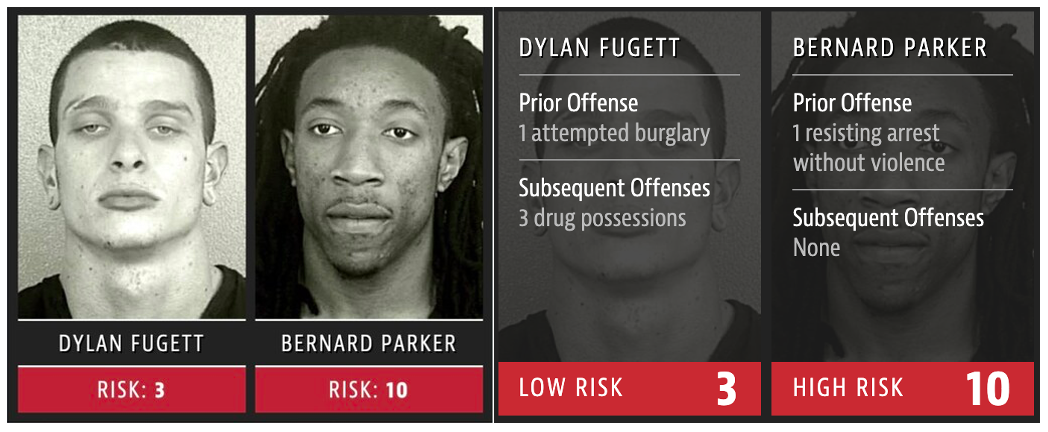

In [ ]:
from IPython.display import Image

Image(filename='/content/drive/MyDrive/EA MAP511/Image PP.png')

Tout algorithme peut faire des erreurs, nul n'est parfait et Northpointe n'aurait pas la prétention de le nier. Cependant, ces images sont trompeuses. En effet, ces aberrations (une personne A sensiblement moins dangereuse qu'une personne B mais A a un score plus élevé que B) n'existent pas dans notre dataset ce qui montre que d'autres éléments n'ont pas été pris en compte pour dresser ce portrait. En affichant ce genre d'images, Propublica ne donne pas toutes les informations ce qui est trompeur.

In [ ]:
white.head()

,id,sex,age,age_cat,race,decile_score,priors_count,c_charge_degree,two_year_recid,juv_fel_count,juv_misd_count,score_factor,felony
6,8,1,41,0,1,6,14,1,1,0,0,1,1
8,10,0,39,0,1,1,0,0,0,0,0,0,0
10,14,1,27,0,1,4,0,1,0,0,0,0,1
12,16,0,37,0,1,1,0,0,0,0,0,0,0
14,19,0,47,1,1,1,1,1,1,0,0,0,1


In [ ]:

count = 0
black=dd[dd['race']==0]
white=dd[dd['race']==1]
for i in range(len(black)):
  for j in range(len(white)):
      # Vérification si toutes les catégories de l'élément i sont supérieures à celles de l'élément j
      all_categories_greater = True
      if black.iloc[i]['felony'] <= white.iloc[j]['felony'] or black.iloc[i]['priors_count'] <= white.iloc[j]['priors_count'] or black.iloc[i]['c_charge_degree'] <= white.iloc[j]['c_charge_degree'] or black.iloc[i]['juv_fel_count'] <= white.iloc[j]['juv_fel_count'] or black.iloc[i]['juv_misd_count'] <= white.iloc[j]['juv_misd_count']:
              all_categories_greater = False
              break
      # Si toutes les catégories de l'élément i sont supérieures à celles de l'élément j, et que j a été classé à risque et pas i
      if all_categories_greater and black.iloc[i]['score_factor'] < white.iloc[j]['score_factor']:
        count += 1

print("Le nombre d'aberrations en défaveur des Caucasiens est :", count)


Le nombre d'aberrations en défaveur des Caucasiens est : 0


In [ ]:

count = 0


for i in range(len(black)):
    for j in range(len(white)):
        # Vérification si toutes les catégories de l'élément i sont supérieures à celles de l'élément j
        all_categories_greater = True

        if black.iloc[i]['felony'] >= white.iloc[j]['felony'] or black.iloc[i]['priors_count'] >= white.iloc[j]['priors_count'] or black.iloc[i]['c_charge_degree'] >= white.iloc[j]['c_charge_degree'] or black.iloc[i]['juv_fel_count'] >= white.iloc[j]['juv_fel_count'] or black.iloc[i]['juv_misd_count'] >= white.iloc[j]['juv_misd_count']:
                all_categories_greater = False
                break

        # Si toutes les catégories de l'élément i sont supérieures à celles de l'élément j, et que j a été classé à risque et pas i
        if all_categories_greater and black.iloc[i]['score_factor'] > white.iloc[j]['score_factor']:
            count += 1

print("Le nombre d'aberrations en défaveur des Afro-américains est :", count)

Le nombre d'aberrations en défaveur des Afro-américains est : 0


Par ailleurs, on pourrait nous rétorquer que même si COMPAS ne fait pas des erreurs aussi importantes, il peut en faire et qu'alors cet algorithme n'est pas bon à utiliser, qu'il n'est pas satisfaisant. À cela nous pouvons répondre par deux arguments.

Le premier est que l'accuracy de 65%, c'est-à-dire le pourcentage de prédictions correctes de COMPAS (par exemple une personne à qui on a attribué un score élevé et qui récidive dans les deux ans), n'est pas l'accuracy exacte. En effet, toutes les personnes qui récidivent ne sont pas forcément arrêtées ou condamnées. De même, certaines personnes récidivent au bout d'une période supérieure à deux ans (qui est la limite qu'on regarde pour déterminer l'accuracy). Ainsi, l'accuracy de 65% est sous-estimée car elle ne prend en compte que les personnes qui ont récidivé au bout de deux ans et qui ont été arrêtées et traduites devant la justice dans cette même période de temps. Ainsi, les critiques consistant à dire que l'accuracy n'est pas satisfaisante et qu'une personne, même sans savoir juridique, pourrait faire aussi bien voire mieux que COMPAS ne sont pas recevables.

Le deuxième est que le score fourni par COMPAS n'est en aucun cas la décision finale mais qu'il est une aide à la prise de décision du juge, un élément parmi d'autres qui vient s'ajouter à un ensemble d'informations que le juge doit synthétiser. COMPAS ne remplace pas la décision du juge, ainsi, si une erreur évidente se produit, c'est à ce dernier de la remarquer et de décider de ne pas prendre en compte le score. Rappelons enfin que COMPAS a été créé comme un outil d'aide à la prise de décision, permettant de limiter certains biais cognitifs. Ainsi, si l'objectif est de rendre plus impartiale la décision humaine, il ne s'agit en aucun cas de la remplacer totalement, et le contrôle humain reste nécessaire.